# HoG and PHoG
author: Stephanie Wang

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imrotate
import skimage.io as sio
from scipy.io import loadmat
import math
from pdb import set_trace as t
from sklearn import preprocessing
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import fbeta_score
import pandas as pd
import os
import seaborn as sns
from glob import glob
import cv2
import warnings
from skimage import feature
from scipy import ndimage
warnings.filterwarnings('ignore')

# HoG Analysis

## Functions: Plot HoG images

In [2]:
# Displays original image along with Canny edges and HoG features
def show_canny_hog(orig, w, canny, figsize = (8,6)):
    w = np.tile(w, [1, 1, 3])
    w = np.pad(w, ((0,0), (0,0), (0,5)), 'constant', constant_values=0.0)

    #  # Make pictures of positive and negative weights
    pos = hog_picture(w)
    neg = hog_picture(-w)

    # Put pictures together and draw
    buff = 10
    if w.min() < 0.0:
        pos = np.pad(pos, (buff, buff), 'constant', constant_values=0.5)
        neg = np.pad(neg, (buff, buff), 'constant', constant_values=0.5)
        im = np.hstack([pos, neg])
    else:
        im = pos

    im[im < 0] = 0.0
    im[im > 1] = 1.0
    plt.figure(figsize=figsize)
    plt.subplot(231)
    plt.imshow(orig, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(232)
    plt.imshow(canny, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(233)
    plt.imshow(im, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

# Displays the HoG features next to the original image
def show_hog(orig, w, figsize = (8,6)):
    w = np.tile(w, [1, 1, 3])
    w = np.pad(w, ((0,0), (0,0), (0,5)), 'constant', constant_values=0.0)

    #  # Make pictures of positive and negative weights
    pos = hog_picture(w)
    neg = hog_picture(-w)

    # Put pictures together and draw
    buff = 10
    if w.min() < 0.0:
        pos = np.pad(pos, (buff, buff), 'constant', constant_values=0.5)
        neg = np.pad(neg, (buff, buff), 'constant', constant_values=0.5)
        im = np.hstack([pos, neg])
    else:
        im = pos

    im[im < 0] = 0.0
    im[im > 1] = 1.0
    plt.figure(figsize = figsize)
    plt.subplot(121)
    plt.imshow(orig, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(122)
    plt.imshow(im, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()


# Make picture of positive HOG weights.
def hog_picture(w, bs = 20):
    # construct a "glyph" for each orientaion
    bim1 = np.zeros((bs, bs))
    bim1[:,int(round(bs/2.0))-1:int(round(bs/2.0))+1] = 1.0
    bim = np.zeros((bs, bs, 9))
    bim[:,:,0] = bim1
    for i in xrange(1,9):
        bim[:,:,i] = imrotate(bim1, -i * float(bs), 'nearest') / 255.0

    # make pictures of positive weights bs adding up weighted glyphs
    w[w < 0] = 0.0
    im = np.zeros((bs * w.shape[0], bs * w.shape[1]))
    for i in xrange(w.shape[0]):
        for j in xrange(w.shape[1]):
            for k in xrange(9):
                im[i * bs : (i+1) * bs, j * bs : (j+1) * bs] += bim[:,:,k] * w[i,j,k+18]

    scale = max(w.max(), -w.max()) + 1e-8
    im /= scale
    return im

## Functions: Compute HOG features

In [3]:
'''
COMPUTE_GRADIENT Given an image, computes the pixel gradients
'''
def compute_gradient(im):
    H, W = im.shape
    xgrad = np.zeros((H-2, W-2))
    ygrad = np.zeros((H-2, W-2))

    xgrad = im[1:-1, :-2] - im[1:-1, 2:]
    ygrad = im[:-2, 1:-1] - im[2:, 1:-1]

    angles = np.arctan2(ygrad, xgrad)
    angles[angles < 0] += math.pi
    angles = np.degrees(angles)
    magnitudes = np.sqrt(xgrad ** 2 + ygrad ** 2)
    return angles, magnitudes
    

'''
GENERATE_HISTOGRAM Given matrices of angles and magnitudes of the image
gradient, generate the histogram of angles
'''
def generate_histogram(angles, magnitudes, nbins = 9):
    histogram = np.zeros(nbins)

    bin_size = float(180 / nbins)

    # iterate over the pixels
    for h in xrange(angles.shape[0]):
        for w in xrange(angles.shape[1]):
            ang = angles[h,w]
            mag = magnitudes[h,w]

            if ang >= 180:
                ang = ang - 180

            # interpolate the votes
            lower_idx = int(ang / bin_size) - 1
            upper_idx = lower_idx + 1

            lower_ang = lower_idx * bin_size + 90/nbins
            upper_ang = upper_idx * bin_size + 90/nbins

            # Account for edge case
            if upper_idx >= nbins:
                upper_idx = 0
            if lower_idx < 0:
                lower_idx = nbins - 1

            lower_diff= abs(ang - lower_ang)
            upper_diff = abs(ang - upper_ang)
            lower_percent = upper_diff/ bin_size
            upper_percent = lower_diff/ bin_size
            histogram[lower_idx] += lower_percent * mag
            histogram[upper_idx] += upper_percent * mag

    return histogram


'''
COMPUTE_HOG_FEATURES Computes the histogram of gradients features
'''
def compute_hog_features(im, pixels_in_cell, cells_in_block, nbins):
    height = im.shape[0] - 2
    width = im.shape[1] - 2 

    angles, magnitudes = compute_gradient(im)

    total_cells_in_block = cells_in_block * pixels_in_cell
    stride = total_cells_in_block / 2
    features = np.zeros((int(math.floor(height / stride)) - 1, 
        int(math.floor(width / stride)) - 1, 
        nbins * cells_in_block * cells_in_block))

    # iterate over the blocks, 50% overlap
    for w in xrange(0, width - total_cells_in_block, stride):
        for h in xrange(0, height - total_cells_in_block, stride):
            block_features = np.zeros((cells_in_block, cells_in_block,  nbins))
            block_magnitude = magnitudes[h:h+total_cells_in_block, 
                w:w+total_cells_in_block]
            block_angle = angles[h:h+total_cells_in_block,
                    w:w+total_cells_in_block]
            
            #  iterate over the cells
            for i in xrange(cells_in_block):
                for j in xrange(cells_in_block):
                    cell_magnitudes = block_magnitude[i * pixels_in_cell:(i+1)
                            * pixels_in_cell,
                            j*pixels_in_cell:(j+1)*pixels_in_cell]
                    cell_angles = block_angle[i * pixels_in_cell:(i+1)
                            * pixels_in_cell,
                            j*pixels_in_cell:(j+1)*pixels_in_cell]
                    block_features[i,j,:] = generate_histogram(cell_angles,
                            cell_magnitudes, nbins)
                           
            block_features = block_features.flatten()
            block_features = block_features \
                / np.sqrt(np.linalg.norm(block_features) ** 2 + .01)
            features[int(math.ceil(h/(stride))),
                int(math.ceil(w/(stride))),:] = block_features

    return features

## Functions: Compute PHoG features

In [4]:
'''
Code credit: http://www.robots.ox.ac.uk/~vgg/research/caltech/phog.html
'''
class PHogFeatures():
    '''
    Computes a PHOG descriptor of an image.
    '''

    def __init__(self):
        pass

    def get_features(self, image_path, bins=9, angle=360., pyramid_levels=3):
        """
        Returns a feature vector containing a PHOG descriptor of a whole image.

        :param image_path: Absolute path to an image
        :param bins: Number of (orientation) bins on the histogram (optimal: 20)
        :param angle: 180 or 360 (optimal: 360)
        :param pyramid_levels: Number of pyramid levels (optimal: 3)
        :return:
        """

        feature_vec = self.phog(image_path, bins, angle, pyramid_levels)
        feature_vec = feature_vec.T[0]  # Transpose vector, take the first array
        return feature_vec

    def phog(self, image_path, bin, angle, pyramid_levels):
        """
        Given and image I, phog computes the Pyramid Histogram of Oriented
        Gradients over L pyramid levels and over a Region Of Interest.

        :param image_path: Absolute path to an image of size MxN (Color or Gray)
        :param bin: Number of (orientation) bins on the histogram
        :param angle: 180 or 360
        :param pyramid_levels: Number of pyramid levels
        :return: Pyramid histogram of oriented gradients
        """

        grayscale_img = cv2.imread(image_path, 0)  # 0 converts it to grayscale

        bh = np.array([])
        bv = np.array([])
        if np.sum(np.sum(grayscale_img)) > 100.:
            # Matlab The default sigma is sqrt(2); the size of the filter is chosen automatically, based on sigma.
            # Threshold is applied automatically - the percentage is a bit different than in Matlab's implementation:
            # low_threshold: 10%
            # high_threshold: 20%
            edges_canny = feature.canny(grayscale_img, sigma=math.sqrt(2))
            [GradientY, GradientX] = np.gradient(np.double(grayscale_img))
            GradientYY = np.gradient(GradientY)[1]  # Take only the first matrix
            Gr = np.sqrt((GradientX * GradientX + GradientY * GradientY))

            index = GradientX == 0.
            index = index.astype(int)  # Convert boolean array to an int array
            GradientX[np.where(index > 0)] = np.power(10, -5)
            YX = GradientY / GradientX

            if angle == 180.:
                angle_values = np.divide((np.arctan(YX) + np.pi / 2.) * 180., np.pi)
            if angle == 360.:
                angle_values = np.divide((np.arctan2(GradientY, GradientX) + np.pi) * 180., np.pi)

            [bh, bv] = self.bin_matrix(angle_values, edges_canny, Gr, angle, bin)
        else:
            bh = np.zeros(image_path.shape[0], image_path.shape[1])
            bv = np.zeros(image_path.shape[0], image_path.shape[1])

        # Don't consider a roi, take the whole image instead
        bh_roi = bh
        bv_roi = bv
        p = self.phog_descriptor(bh_roi, bv_roi, pyramid_levels, bin)

        return p

    def bin_matrix(self, angle_values, edge_image, gradient_values, angle, bin):
        """
        Computes a Matrix (bm) with the same size of the image where
        (i,j) position contains the histogram value for the pixel at position (i,j)
        and another matrix (bv) where the position (i,j) contains the gradient
        value for the pixel at position (i,j)

        :param angle_values: Matrix containing the angle values
        :param edge_image: Edge Image
        :param gradient_values: Matrix containing the gradient values
        :param angle: 180 or 360
        :param bin: Number of bins on the histogram
        :return: bm - Matrix with the histogram values
                bv - Matrix with the gradient values (only for the pixels belonging to and edge)
        """

        # 8-orientations/connectivity structure (Matlab's default is 8 for bwlabel)
        structure_8 = [[1, 1, 1],
                       [1, 1, 1],
                       [1, 1, 1]]

        [contorns, n] = ndimage.label(edge_image, structure_8)
        X = edge_image.shape[1]
        Y = edge_image.shape[0]
        bm = np.zeros((Y, X))
        bv = np.zeros((Y, X))
        nAngle = np.divide(angle, bin)
        for i in np.arange(1, n + 1):
            [posY, posX] = np.nonzero(contorns == i)
            posY = posY + 1
            posX = posX + 1
            for j in np.arange(1, (posY.shape[0]) + 1):
                pos_x = posX[int(j) - 1]
                pos_y = posY[int(j) - 1]
                b = np.ceil(np.divide(angle_values[int(pos_y) - 1, int(pos_x) - 1], nAngle))
                if b == 0.:
                    bin = 1.
                if gradient_values[int(pos_y) - 1, int(pos_x) - 1] > 0:
                    bm[int(pos_y) - 1, int(pos_x) - 1] = b
                    bv[int(pos_y) - 1, int(pos_x) - 1] = gradient_values[int(pos_y) - 1, int(pos_x) - 1]

        return [bm, bv]

    def phog_descriptor(self, bh, bv, pyramid_levels, bin):
        """
        Computes Pyramid Histogram of Oriented Gradient over an image.

        :param bh: Matrix of bin histogram values
        :param bv: Matrix of gradient values
        :param pyramid_levels: Number of pyramid levels
        :param bin: Number of bins
        :return: Pyramid histogram of oriented gradients (phog descriptor)
        """

        p = np.empty((0, 1), dtype=int)  # dtype=np.float64? # vertical size 0, horizontal 1

        for b in np.arange(1, bin + 1):
            ind = bh == b
            ind = ind.astype(int)  # convert boolean array to int array
            sum_ind = np.sum(bv[np.where(ind > 0)])
            p = np.append(p, np.array([[sum_ind]]), axis=0)  # append the sum horizontally to empty p array

        cella = 1.
        for l in np.arange(1, pyramid_levels + 1):  # defines a range (from, to, step)
            x = np.fix(np.divide(bh.shape[1], 2. ** l))
            y = np.fix(np.divide(bh.shape[0], 2. ** l))
            xx = 0.
            yy = 0.
            while xx + x <= bh.shape[1]:
                while yy + y <= bh.shape[0]:
                    bh_cella = np.array([])
                    bv_cella = np.array([])
                    bh_cella = bh[int(yy + 1.) - 1:yy + y, int(xx + 1.) - 1:xx + x]
                    bv_cella = bv[int(yy + 1.) - 1:yy + y, int(xx + 1.) - 1:xx + x]

                    for b in np.arange(1, bin + 1):
                        ind = bh_cella == b
                        ind = ind.astype(int)  # convert boolean array to int array
                        sum_ind = np.sum(bv_cella[np.where(ind > 0)])
                        p = np.append(p, np.array([[sum_ind]]), axis=0)  # append the sum horizontally to p

                    yy = yy + y

                cella = cella + 1.
                yy = 0.
                xx = xx + x

        if np.sum(p) != 0:
            p = np.divide(p, np.sum(p))

        return p

## Test HOG on Car

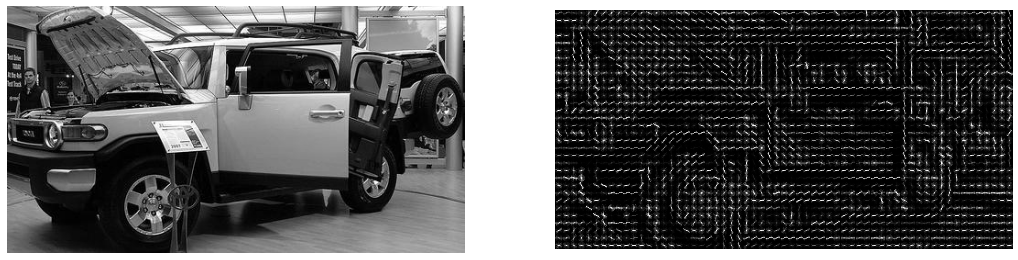

In [5]:
pixels_in_cell = 8
cells_in_block = 2
nbins = 9
im = sio.imread('../images/car.jpg', True)
car_hog_feat = compute_hog_features(im, pixels_in_cell, cells_in_block, nbins)
show_hog(im, car_hog_feat, figsize = (18,6))

## Test HOG on set of Sat images

### Import Satellite Images

In [6]:
df = pd.read_csv('../data/train.csv')
image_paths = sorted(glob('../data/train-jpg/*.jpg'))
image_names = list(map(lambda row: row.split("/")[-1][:-4], image_paths))

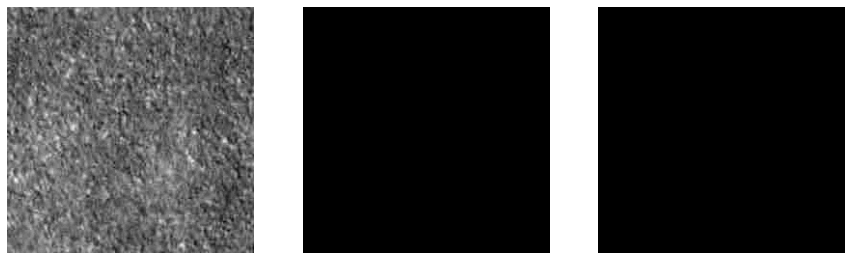

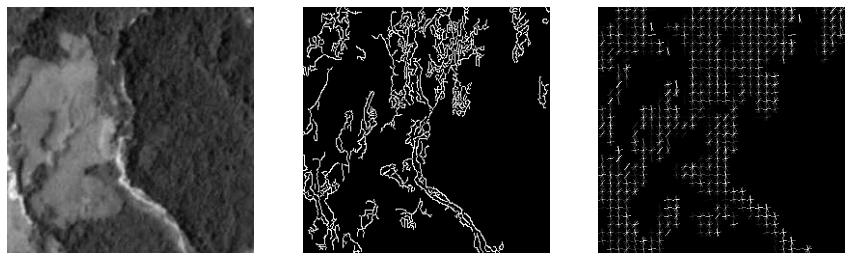

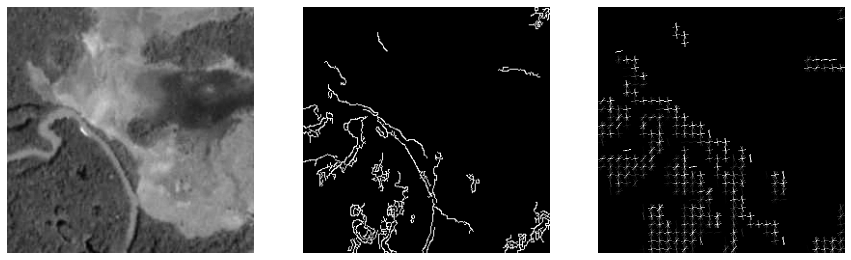

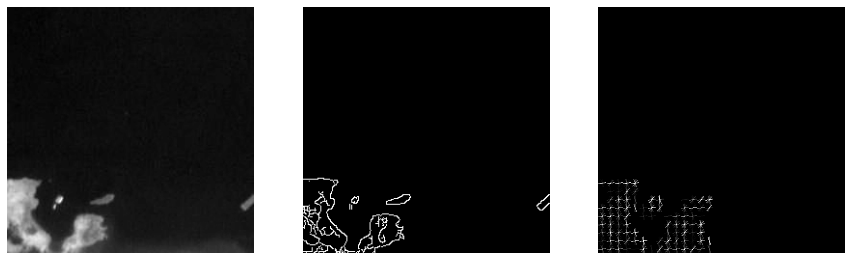

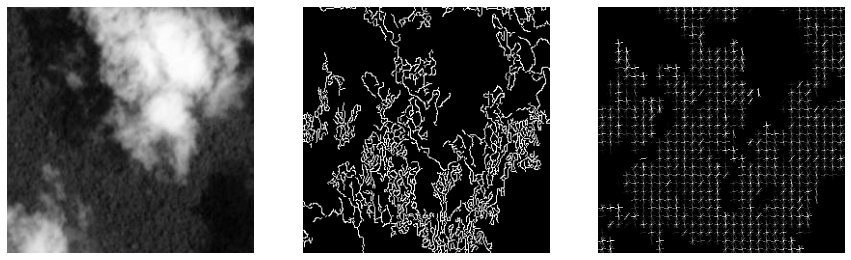

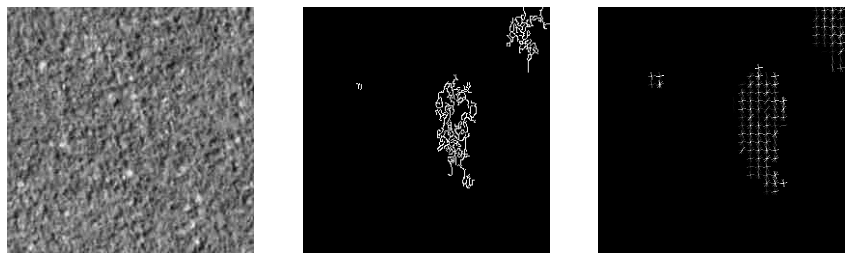

In [7]:
pixels_in_cell = 8
cells_in_block = 2
rescaled_dim = 100
nbins = 9
for i in range(6):
    im = cv2.imread(image_paths[i], 0)
    #im_scaled = cv2.normalize(im, im, alpha=-0.5, beta=0.5, norm_type=cv2.NORM_MINMAX)
    #im = cv2.resize(im, (0, 0), fx=0.5, fy=0.5)
    im_edges = cv2.Canny(im, 10, 100)
    hog_feat = compute_hog_features(im_edges, pixels_in_cell, cells_in_block, nbins)
    show_canny_hog(im, hog_feat, im_edges, figsize = (15, 15))

### Function: Compute F-2 score

In [8]:
# Using a trained model, calculate the F2_score
# input: X_test, y_test, model
# output: a list of F2_score by class(length 17)
def calc_F2_score(X_test, y_test, model):
    score = fbeta_score(y_test, model.predict(X_test), beta=2, average=None)
    #avg_sample_score = fbeta_score(y_test, model.predict(X_test), beta=2, average='samples')
    #print('Average F2 test score {}'.format(avg_sample_score))
    #print('F2 test scores per tag:')
    #[(lb.classes_[l], score[l]) for l in score.argsort()[::-1]]
    return score

## HOG features on Sat images

### Training

In [27]:
n_samples = 500
df['split_tags'] = df['tags'].map(lambda row: row.split(" "))
lb = MultiLabelBinarizer()
y = lb.fit_transform(df['split_tags'])
y = y[:n_samples]

In [28]:
features = []
n_samples = 500 #small sampling dataset
pixels_in_cell = 8
cells_in_block = 2
nbins = 9

for name in df.head(n_samples)['image_name'].values:
    phog = PHogFeatures()
    raw_img = cv2.imread('../data/train-jpg/{}.jpg'.format(name))
    raw_img = cv2.resize(im, (0, 0), fx=0.5, fy=0.5)
    im_edges = cv2.Canny(raw_img, 10, 100)
    hog_feat = compute_hog_features(im_edges, pixels_in_cell, cells_in_block, nbins)
    combined_feat = np.append(hog_feat.reshape(1, -1), raw_img.reshape(1, -1))
    features.append(combined_feat.reshape(1, -1))

X = np.squeeze(np.array(features))
print "X shape:", X.shape

X shape: (500, 23440)


In [29]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((335, 23440), (165, 23440), (335, 17), (165, 17))


### Test Support Vector Classification

In [30]:
clf = OneVsRestClassifier(LinearSVC(penalty='l2'))
clf.fit(X_train, y_train)
score = calc_F2_score(X_test, y_test, clf)

avg_sample_score = fbeta_score(y_test, clf.predict(X_test), beta=2, average='samples')

print('Average F2 test score {}'.format(avg_sample_score))
print('SVC_F2 test scores per tag:')
[(lb.classes_[l], score[l]) for l in score.argsort()[::-1]]

Average F2 test score 0.647788911425
SVC_F2 test scores per tag:


[('primary', 0.9859154929577465),
 ('clear', 0.92000000000000004),
 ('water', 0.0),
 ('conventional_mine', 0.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('cloudy', 0.0),
 ('cultivation', 0.0),
 ('slash_burn', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('agriculture', 0.0)]

## PHOG on Sat images

### Training

In [31]:
df = pd.read_csv('../data/train.csv')
image_paths = sorted(glob('../data/train-jpg/*.jpg'))
image_names = list(map(lambda row: row.split("/")[-1][:-4], image_paths))

n_samples = 500
df['split_tags'] = df['tags'].map(lambda row: row.split(" "))
lb = MultiLabelBinarizer()
y = lb.fit_transform(df['split_tags'])
y = y[:n_samples]

In [32]:
features = []
n_samples = 500 #small sampling dataset

for name in df.head(n_samples)['image_name'].values:
    phog = PHogFeatures()
    raw_img = cv2.imread('../data/train-jpg/{}.jpg'.format(name))
    raw_img = cv2.resize(im, (0, 0), fx=0.5, fy=0.5)
    phog_feat = phog.get_features('../data/train-jpg/{}.jpg'.format(name))
    combined_feat = np.append(phog_feat.reshape(1, -1), raw_img.reshape(1, -1))
    features.append(combined_feat.reshape(1, -1))

X = np.squeeze(np.array(features))
print "X shape:", X.shape

X shape: (500, 17149)


In [33]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((335, 17149), (165, 17149), (335, 17), (165, 17))


### Test Support Vector Classifcation

In [34]:
clf = OneVsRestClassifier(LinearSVC(penalty='l2'))
clf.fit(X_train, y_train)
score = calc_F2_score(X_test, y_test, clf)

avg_sample_score = fbeta_score(y_test, clf.predict(X_test), beta=2, average='samples')

print('Average F2 test score {}'.format(avg_sample_score))
print('SVC_F2 test scores per tag:')
[(lb.classes_[l], score[l]) for l in score.argsort()[::-1]]

Average F2 test score 0.641289192091
SVC_F2 test scores per tag:


[('primary', 0.98039215686274495),
 ('clear', 0.9360730593607306),
 ('agriculture', 0.64516129032258074),
 ('road', 0.56478405315614622),
 ('partly_cloudy', 0.43478260869565216),
 ('cultivation', 0.36480686695278969),
 ('haze', 0.0),
 ('habitation', 0.0),
 ('slash_burn', 0.0),
 ('conventional_mine', 0.0),
 ('cloudy', 0.0),
 ('selective_logging', 0.0),
 ('blow_down', 0.0),
 ('blooming', 0.0),
 ('bare_ground', 0.0),
 ('artisinal_mine', 0.0),
 ('water', 0.0)]

## Train and Test Model with Entire Data PHoG

In [10]:
NUM_TRAIN = 40482
NUM_SAMPLE = NUM_TRAIN
DIM = 32
df = pd.read_csv('../data/train.csv')
image_paths = sorted(glob('../data/train-jpg/*.jpg'))
image_names = list(map(lambda row: row.split("/")[-1][:-4], image_paths))

df['split_tags'] = df['tags'].map(lambda row: row.split(" "))
lb = MultiLabelBinarizer()
y = lb.fit_transform(df['split_tags'])
y = y[:NUM_SAMPLE]
features = []

### Train 

In [ ]:
for name in df.head(NUM_SAMPLE)['image_name'].values:
    phog = PHogFeatures()
    raw_img = cv2.imread('../data/train-jpg/{}.jpg'.format(name))
    raw_img = cv2.resize(im, (0, 0), fx=0.5, fy=0.5)
    phog_feat = phog.get_features('../data/train-jpg/{}.jpg'.format(name))
    combined_feat = np.append(phog_feat.reshape(1, -1), raw_img.reshape(1, -1))
    features.append(combined_feat.reshape(1, -1))

X = np.squeeze(np.array(features))
print "X shape:", X.shape 

### Test

In [ ]:
clf = OneVsRestClassifier(LinearSVC(penalty='l2'))
clf.fit(X_train, y_train)
score = calc_F2_score(X_test, y_test, clf)

avg_sample_score = fbeta_score(y_test, clf.predict(X_test), beta=2, average='samples')

print('Average F2 test score {}'.format(avg_sample_score))
print('SVC_F2 test scores per tag:')
[(lb.classes_[l], score[l]) for l in score.argsort()[::-1]]